In [47]:
import numpy as np
import torch
import imageio.v2 as imageio
import cv2
from PIL import Image
from pathlib import Path

# Importing D2Net related modules from third-party directory
sys.path.append("third_party/d2net/")
from lib.model_test import D2Net
from lib.utils import preprocess_image
from lib.pyramid import process_multiscale


class D2NetExtractor:
    def __init__(self, max_kp, detection_threshold, resize_to=640, model_file="/home/niranjan/recons3d/third_party/d2net/models/d2_tf_no_phototourism.pth"):
        self.max_kp = max_kp
        self.detection_threshold = detection_threshold
        self.resize_to = resize_to

        # CUDA
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if self.use_cuda else "cpu")

        # Creating CNN model
        self.model = D2Net(
            model_file=model_file,
            use_relu=True,
            use_cuda=self.use_cuda
        )

    def sort_and_filter(self, A, B, scores, max_rows, score_threshold):
        # Convert to numpy arrays if they aren't already
        A = np.array(A)
        B = np.array(B)
        scores = np.array(scores)

        # Sort by scores in descending order
        sorted_indices = np.argsort(scores)[::-1]
        A = A[sorted_indices]
        B = B[sorted_indices]
        scores = scores[sorted_indices]

        # Filter based on score threshold
        valid_indices = scores >= score_threshold
        A = A[valid_indices]
        B = B[valid_indices]
        scores = scores[valid_indices]

        # Limit the number of rows to max_rows
        if len(scores) > max_rows:
            A = A[:max_rows]
            B = B[:max_rows]
            scores = scores[:max_rows]

        return A, B, scores

    def extract(self, im_path):
        image = imageio.imread(im_path)
        if len(image.shape) == 2:
            image = image[:, :, np.newaxis]
            image = np.repeat(image, 3, -1)

        # Resize image if needed
        resized_image = image
        if max(resized_image.shape) > self.resize_to:
            resized_image = cv2.resize(
                resized_image, None, None,
                self.resize_to / max(resized_image.shape), self.resize_to / max(resized_image.shape)
            ).astype('float')
        if sum(resized_image.shape[:2]) > 2800:
            resized_image = cv2.resize(
                resized_image, None, None,
                2800 / sum(resized_image.shape[:2]), 2800 / sum(resized_image.shape[:2])
            ).astype('float')

        fact_i = image.shape[0] / resized_image.shape[0]
        fact_j = image.shape[1] / resized_image.shape[1]

        input_image = preprocess_image(
            resized_image,
            preprocessing="caffe"
        )
        with torch.no_grad():
            keypoints, scores, descriptors = process_multiscale(
                torch.tensor(
                    input_image[np.newaxis, :, :, :].astype(np.float32),
                    device=self.device
                ),
                self.model,
                scales=[1]
            )

        # Input image coordinates
        keypoints[:, 0] *= fact_i
        keypoints[:, 1] *= fact_j
        # i, j -> u, v
        keypoints = keypoints[:, [1, 0, 2]]
        keypoints, descriptors, scores = self.sort_and_filter(keypoints, descriptors, scores / scores.max(), self.max_kp, self.detection_threshold)

        return {"keypoints": keypoints, "descriptors": descriptors, "scores": scores}



In [49]:
extractor = D2NetExtractor(4000, 0.01)
res1 = extractor.extract("/home/niranjan/recons3d/dataset/train/church/images/00001.png")
res2 = extractor.extract("/home/niranjan/recons3d/dataset/train/church/images/00002.png")

In [51]:
import cv2
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = matcher.match(res1['descriptors'], res2['descriptors'] )
matches = (sorted(matches, key=lambda x: x.distance))
matches = np.array([[match.queryIdx, match.trainIdx] for match in matches])


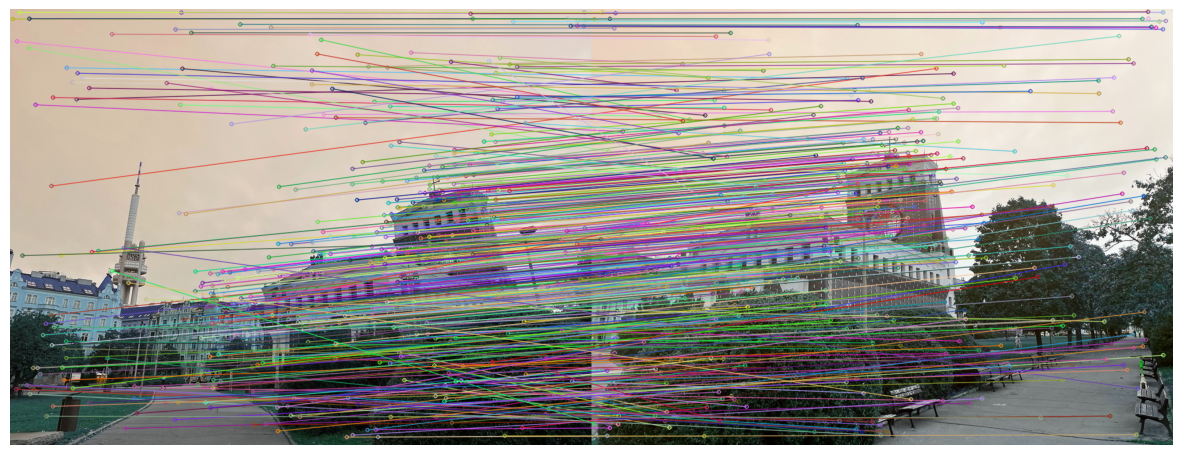

In [52]:
image1 = cv2.imread("/home/niranjan/recons3d/dataset/train/church/images/00001.png",-1)
image2 = cv2.imread("/home/niranjan/recons3d/dataset/train/church/images/00002.png",-1)
keypoints_left = res1['keypoints'][matches[:, 0], : 2]
keypoints_right = res2['keypoints'][matches[:, 1], : 2]
inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_left]
inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in keypoints_right]
placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(len(inlier_keypoints_left))]
image3 = cv2.drawMatches(image1, inlier_keypoints_left, image2, inlier_keypoints_right, placeholder_matches, None, None)
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.imshow(image3)
plt.axis('off')
plt.show()

In [62]:
import pycolmap
import sfm.metric
import sfm.utils
import pandas as pd
from copy import deepcopy
def colmap_to_df(recons_path, input_df):
    recons = pycolmap.Reconstruction()
    recons.read_binary(recons_path)
    results = {}        
    data_dict = sfm.utils.df_to_dict(input_df)
    datasets = list(data_dict.keys())

    for dataset in datasets:
        if dataset not in results:
            results[dataset] = {}

        for scene in data_dict[dataset]:
            images_dir = data_dict[dataset][scene][0].parent
            results[dataset][scene] = {}
            image_paths = data_dict[dataset][scene]

            for k, im in recons.images.items():
                key = Path("./dataset/train") / scene / "images" / im.name
                results[dataset][scene][key] = {}
                results[dataset][scene][key]["R"] = deepcopy(im.rotmat())
                results[dataset][scene][key]["t"] = deepcopy(np.array(im.tvec))

    return sfm.utils.dict_to_df(results, data_dict)

def image_path(row):
    row['image_path'] = "train/" + row['dataset'] + '/images/' + row['image_name']
    return row

def compute_score(recons_path, dataset):
    gt_df =  pd.read_csv("./dataset/train/train_labels.csv")
    gt_df = gt_df[gt_df["dataset"]==dataset]
    gt_df = gt_df.apply(image_path, axis=1).drop_duplicates(subset=['image_path'])
    colmap_df = colmap_to_df(recons_path, gt_df)
    return sfm.metric.score(gt_df, colmap_df)



In [63]:
compute_score("/home/niranjan/recons3d/dataset/train/church/DetectorFreeSfM_loftr_official_coarse_fine__scratch_no_intrin/colmap_refined", "church")


church / church -> 110 images

*** church ***

mAA: 0.2009


0.20093457943925233

In [64]:
compute_score("/home/niranjan/recons3d/dataset/train/church/DetectorFreeSfM_loftr_official_coarse_only__scratch_no_intrin/colmap_refined", "church")

church / church -> 110 images

*** church ***

mAA: 0.1916


0.19158878504672897